# Audio Classification: Data Exploration and Preprocessing

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Initial Data Exploration and Mel-spectrogram Visualization

## Overview

This notebook serves as the initial exploration phase for an audio classification project. We will:
1. Load and inspect audio waveform data from WAV files
2. Visualize audio signals in the time domain
3. Transform audio into mel-spectrogram representations suitable for deep learning
4. Visualize frequency-time representations

The goal is to understand the audio data structure and prepare it for training a Convolutional Neural Network (CNN) for classification tasks.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pathlib import Path


## Library Dependencies

This notebook relies on the following Python libraries:

- **`numpy`**: Fundamental library for numerical computations, array operations, and mathematical functions. Essential for handling audio data as arrays.

- **`matplotlib.pyplot`**: Visualization library for creating plots and figures. Used to display audio waveforms and spectrograms.

- **`librosa`**: Comprehensive audio analysis library that provides:
  - `librosa.load()`: Loads audio files (WAV, MP3, etc.) as numpy arrays
  - `librosa.feature.melspectrogram()`: Computes mel-scale spectrograms from audio signals
  - `librosa.display`: Specialized plotting functions for audio visualizations

- **`pathlib.Path`**: Modern Python path handling that provides platform-independent file path operations. More robust than string-based paths.


In [ ]:
# Define the data directory path
# Since this notebook is located in notebooks/, we navigate up one directory level
# to reach the project root where the data/ folder is located
# The .resolve() method converts the path to an absolute path for reliability
DATA_DIR = Path("../data").resolve()

# Select an example audio file from the dog class for exploration
example_audio_path = DATA_DIR / "dog" / "0d53e045_nohash_0.wav"

# Verify the file path and existence
print("Audio file path:", example_audio_path)
print("Does this file exist?", example_audio_path.exists())

Audio file path: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data/dog/0d53e045_nohash_0.wav
Does this file exist? True


## Step 1: Loading Audio Data

In this section, we load the audio file from disk into memory. The `librosa.load()` function:
- Reads the WAV file and converts it to a floating-point audio signal
- Normalizes the amplitude to the range [-1, 1]
- Optionally resamples the audio to a specified sample rate (16000 Hz in our case)
- Returns the audio signal (`y`) and the sample rate (`sr`)

In [ ]:
# Load the audio file as a waveform
# sr=16000 ensures all audio files are resampled to 16 kHz for consistency
y, sr = librosa.load(example_audio_path, sr=16000)

# Display audio file properties
print("Waveform shape:", y.shape)
print("Sample rate:", sr, "Hz")

# Calculate audio duration: number of samples divided by sample rate
duration = len(y) / sr
print(f"Duration: {duration:.2f} seconds")


Waveform shape: (16000,)
Sample rate: 16000 Hz
Duration: 1.00 seconds


### Audio Data Structure

- **`y`**: A 1D NumPy array containing the audio waveform samples. The shape is `(n_samples,)` where `n_samples = duration × sample_rate`. For example, a 1-second audio file at 16 kHz has shape `(16000,)`.

- **`sr`**: The sample rate in Hz (samples per second). We standardize all audio files to 16 kHz to ensure uniform input dimensions for the neural network.

- **`duration`**: The audio duration in seconds, calculated as `n_samples / sample_rate`. This helps verify that files meet our expected length requirements.

## Step 2: Visualizing the Audio Waveform

A waveform visualization shows how the audio amplitude changes over time. This is the most intuitive representation of audio data in the time domain. The plot helps us:
- Verify that the audio loaded correctly
- Inspect the amplitude envelope and temporal characteristics
- Identify any potential issues with the audio signal

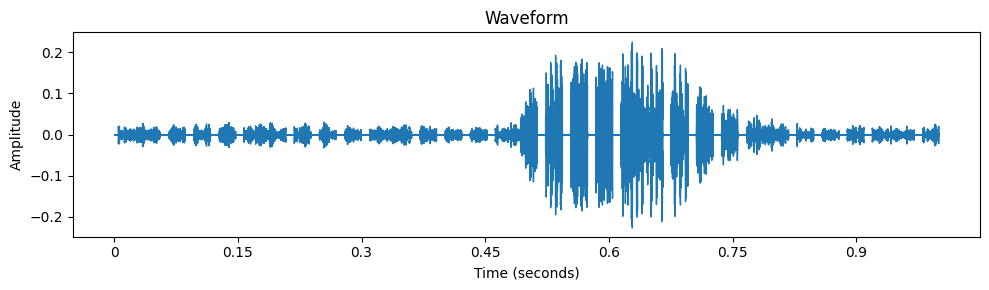

In [ ]:
# Create a waveform visualization
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform - Time Domain Representation")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


## Step 3: Computing the Mel-Spectrogram

While waveforms show audio in the time domain, neural networks for audio classification typically work better with frequency-domain representations. A **mel-spectrogram** is a 2D representation that shows:
- **Frequency content** (vertical axis) in the mel scale (a perceptual frequency scale that mimics human hearing)
- **Time** (horizontal axis)
- **Energy/intensity** (color intensity) at each frequency-time combination

This transformation converts a 1D audio signal into a 2D "image" that CNNs can process effectively.

### Mel-Spectrogram Parameters

The mel-spectrogram computation involves several key parameters:

- **`n_fft`**: Window size for the Fast Fourier Transform (FFT). Larger values provide better frequency resolution but worse time resolution. A value of 1024 is a common balance.

- **`hop_length`**: Number of samples between successive FFT windows. Determines the temporal resolution. Smaller values give more time frames but increase computation. Typically set to `n_fft // 2` (512 here).

- **`n_mels`**: Number of mel frequency bands. More bands provide finer frequency granularity but increase dimensionality. 128 is a standard choice that captures sufficient detail for classification.

- **`power`**: Exponent for the magnitude spectrum. `power=2.0` computes the power spectrogram (squared magnitude), which is commonly used in audio analysis.

In [ ]:
# Configure mel-spectrogram parameters
n_fft = 1024       # FFT window size (controls frequency resolution)
hop_length = 512   # Samples between successive windows (controls time resolution)
n_mels = 128       # Number of mel frequency bands (vertical resolution)

# Compute the mel-spectrogram from the audio waveform
S = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    power=2.0,  # Compute power spectrogram (squared magnitude)
)

print("Mel-spectrogram shape:", S.shape)
print(f"  - Frequency bins (mel bands): {S.shape[0]}")
print(f"  - Time frames: {S.shape[1]}")


Mel-spectrogram shape: (128, 32)


In [ ]:
# Convert power spectrogram to decibel (dB) scale
# This transformation improves visualization and neural network training:
# 1. Compresses the dynamic range for better contrast
# 2. More closely matches human perception of loudness (logarithmic)
# 3. Helps with gradient stability during training
S_db = librosa.power_to_db(S, ref=np.max)
print("Mel-spectrogram (dB) shape:", S_db.shape)


Mel-spectrogram (dB) shape: (128, 32)


### Mel-Spectrogram Structure

- **`S`**: The raw mel-spectrogram is a 2D NumPy array of shape `(n_mels, T)`:
  - **First dimension (`n_mels = 128`)**: Represents mel frequency bands (vertical axis). Lower indices correspond to lower frequencies, higher indices to higher frequencies.
  - **Second dimension (`T`)**: Represents time frames (horizontal axis). The number of frames depends on audio duration and `hop_length`.

- **`S_db`**: The log-scale version (decibels) has the same shape as `S` but with values converted to dB. This representation:
  - Better matches human auditory perception (logarithmic scale)
  - Improves visualization contrast
  - Is more suitable for CNN training due to normalized dynamic range

**This `S_db` array is the 2D "image" representation that will be fed into the Convolutional Neural Network for classification.** Each sample in the dataset will be transformed into a mel-spectrogram with consistent dimensions, making it suitable for batch processing and CNN input.


## Step 4: Visualizing the Mel-Spectrogram

The mel-spectrogram visualization provides a comprehensive view of the audio's frequency content over time. This is the representation that will be used as input to our CNN. The visualization helps us:
- Understand the frequency patterns in the audio
- Verify that the transformation was computed correctly
- Inspect the temporal evolution of different frequency components

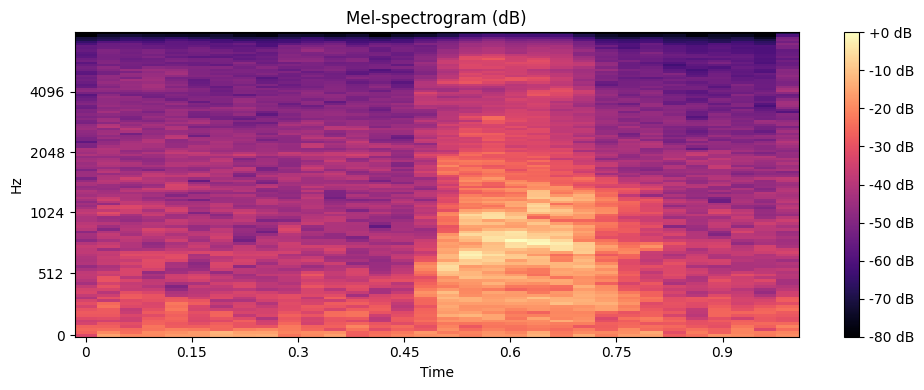

In [ ]:
# Visualize the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    S_db,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",  # Display time on x-axis
    y_axis="mel"    # Display mel frequency scale on y-axis
)
plt.colorbar(format="%+2.0f dB", label="Power (dB)")
plt.title("Mel-Spectrogram: Frequency-Time Representation")
plt.xlabel("Time (seconds)")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()
